# 1 ) Data Preprocessing and Exploring


### Data Download

In [4]:
# Download the data
from data_loading import folder_download
!wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
# Download the data
folder_id = "0B7EVK8r0v71pWEZsZE9oNnFzTm8"
folder_download(folder_id=folder_id)

% cd /content/CelebA/Img/
!unzip img_align_celeba.zip

KeyboardInterrupt: ignored

## Imports

In [ ]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import os
import data_loading
from data_loading import Data_Generation, Load_Data
import model
import train

parser = argparse.ArgumentParser()

In [ ]:
parser = argparse.ArgumentParser()

In [ ]:
# create directory to be used in the codes.

!mkdir /content/CelebA/checkpoints
!mkdir /content/CelebA/categorical
!mkdir /content/CelebA/training_log
!mkdir /content/CelebA/images

!mkdir /content/CelebA/images/full
!mkdir /content/CelebA/images/classes
!mkdir /content/CelebA/images/disrc
!mkdir /content/CelebA/images/random

In [ ]:
# Move the list_attr_celeba_2.csv to Anno
import shutil
shutil.move("/content/list_attr_celeba_2.csv", "/content/CelebA/Anno/") 


'/content/CelebA/Anno/list_attr_celeba_2.csv'

In [ ]:
parser.add_argument('--CSVPATH',
                    type=str,
                    default = "/content/CelebA/Anno/list_attr_celeba_2.csv",
                    help = "path to file of list attribute")

parser.add_argument('--CHECKPOINTS',
                    type=str,
                    default = "/content/CelebA/checkpoints",
                    help = "path to save model checkpoints")

parser.add_argument('--NUMPY_FILES',
                    type=str,
                    default = "/content/CelebA/categorical",
                    help = "path to numpy saved images and labels as .npy files in the range [-1;1]")

parser.add_argument('--LOG',
                    type=str,
                    default = "/content/CelebA/training_log",
                    help = "path to training logs") 

parser.add_argument('--IMAGES',
                    type=str,
                    default = "/content/CelebA/images",
                    help = "directory of all generated images during training/testing.") 


parser.add_argument('--FULL_SAVE',
                    type=str,
                    default = "/content/CelebA/images/full"
                   ) 

parser.add_argument('--CLASSES_SAVE',
                    type=str,
                    default = "/content/CelebA/images/classes"
                   ) 

parser.add_argument('--DISCR_SAVE',
                    type=str,
                    default = "/content/CelebA/images/disrc"
                    ) 

parser.add_argument('--RANDOM_SAVE',
                    type=str,
                    default = "/content/CelebA/Images/random"
                    ) 

parser.add_argument('--ATTRIBUTE_HISTOGRAM',
                    type=str,
                    default = "/content/CelebA/images/attributes_histo.png",
                    help = "path to save attribute histrogram image") 

parser.add_argument('--ATTRIBUTE_DISTRIBUTION',
                    type=str,
                    default = "/content/CelebA/images/attributes_distr.png",
                    help = "path to save attribute distribution image") 

parser.add_argument('--DATA_PATH',
                    type=str,
                    default = "/content/CelebA/Img/img_align_celeba",
                    help = "path to the actual images from the celeba dataset")

parser.add_argument('--IMAGE_SIZE',
                    type=int,
                    default = 128,
                    help = "size of the image") 

parser.add_argument('--NUMBER_OF_CLASSES',
                    type=int,
                    default = 3, 
                    help = "total number of classes")

parser.add_argument('--BATCH_SIZE',
                    type=int,
                    default = 128, 
                    help = "batch size") 
args, _ = parser.parse_known_args()

In [ ]:
# read the data attribute file
df = pd.read_csv(args.CSVPATH, delimiter=";")

## Exploration

### How many attributes / picture on average

In [ ]:
no_fn = df.drop("filename", axis=1)

In [ ]:
avg = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate("average")
std = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate(np.std)
df_min = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate(np.min)
df_max = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate(np.max)
counts_series = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2)

In [ ]:
# Get the Indices of the highest and lowest amount of attributes per person
low_index = counts_series[counts_series==1].index[0]
high_index = counts_series[counts_series==20].index[0]

# Get the corresponding image-filenames
print(f"Only one attribute: \t{df.iloc[low_index].filename}")
print(f"Twenty attribute: \t{df.iloc[high_index].filename}")

Only one attribute: 	003259.jpg
Twenty attribute: 	014308.jpg


In [ ]:
print(f"Average of Attributes/Person: \t{np.round(avg, decimals = 2)}")
print(f"Std of Attributes/Person: \t{np.round(std, decimals = 2)}")
print(f"Lowest amount of attributes: \t{np.round(df_min, decimals = 2)}")
print(f"Highest amount of attributes: \t{np.round(df_max, decimals = 2)}")

Average of Attributes/Person: 	9.03
Std of Attributes/Person: 	2.94
Lowest amount of attributes: 	1
Highest amount of attributes: 	20


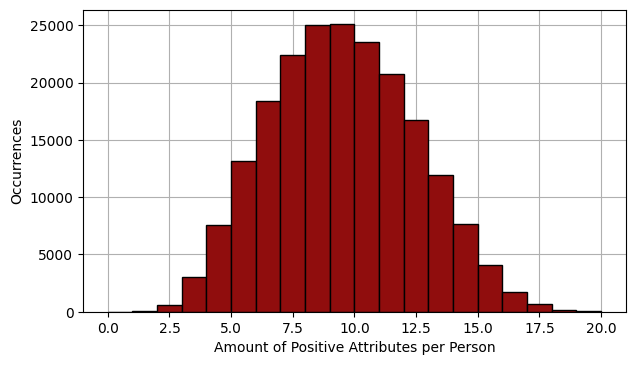

In [ ]:
fig = plt.figure(figsize=(7,4),dpi=100)
plt.rc('axes', axisbelow=True)
plt.hist(counts_series, bins=20, color = "#900d0d", edgecolor= "black", range=(0,20))
plt.grid()
plt.xlabel("Amount of Positive Attributes per Person")
plt.ylabel("Occurrences")
plt.savefig(args.ATTRIBUTE_HISTOGRAM, dpi=300)
plt.show()

### Distribution of Attributes

In [ ]:
no_fn = df.drop("filename", axis=1)

In [ ]:
totals = no_fn.add(1,axis=0).sum(axis=0)//2

In [ ]:
value = list(np.linspace(0.3,0.8, num=40))
N = 40
HSV_tuples = [(0.01, 0.9, value[x]) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
list_rgb = list(RGB_tuples)[::-1]

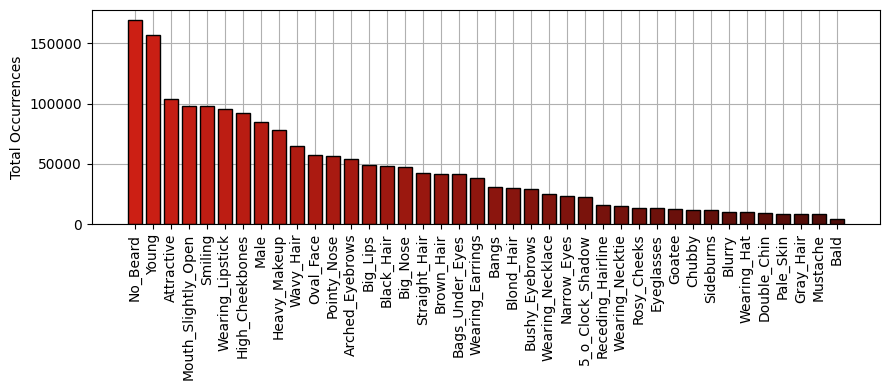

In [ ]:
fig = plt.figure(figsize=(9,4),dpi=100)

plt.rc('axes', axisbelow=True)
plt.grid()
barlist = plt.bar(totals.sort_values(ascending=False).index, totals.sort_values(ascending=False), align="center", edgecolor="black")
plt.xticks(rotation='vertical')
for i in range(len(barlist)):
    barlist[i].set_color(list_rgb[i])
    barlist[i].set_edgecolor("black")
plt.ylabel("Total Occurrences")
plt.tight_layout()
plt.savefig(args.ATTRIBUTE_DISTRIBUTION, dpi=300)
plt.show()

## Create numpy files

In [ ]:
Data_Generation(args, df)

Attribute Eyeglasses found 12000 examples.
Looking for file: /content/CelebA/categorical/training_data_128_128_Eyeglasses_12000.npy
Loading previous training pickle...
Attribute Rosy_Cheeks found 12000 examples.
Looking for file: /content/CelebA/categorical/training_data_128_128_Rosy_Cheeks_12000.npy
Loading previous training pickle...
Attribute Goatee found 12000 examples.
Looking for file: /content/CelebA/categorical/training_data_128_128_Goatee_12000.npy
Loading previous training pickle...


# 2) Conditional DCGAN

## Loading the Data - conditional GAN


In [ ]:
X.shape, y.shape

((36000, 128, 128, 3), (36000,))

In [ ]:
X, y = Load_Data(args)

## Training

In [ ]:
# initialize models
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = model.define_cond_discriminator(args)
# create the generator
g_model = model.define_cond_generator(100, args)
# create the gan
gan_model = model.define_cond_gan(g_model, d_model)

In [ ]:
train.Training(g_model, d_model, gan_model, X, y, latent_dim, args, n_epochs=10000, prefix="final_", epoch_start=0)

In [ ]:
# ONLY here is the prefix not ending with _ due to the pattern matching process of finding the right file
#n_epoch = load_latest_model(d_model, g_model, os.path.join(FACEDATADIR, "checkpoints"), prefix="full40_cDCGAN")

In [ ]:
# If we already have some pretrained weights, load it
import glob
#epoch =  Epich number

# check if the model already exists.
# if it exist, that means we have already trained it before, 
# and will use these weights, it will start training from where we left off.
PATH_MODEL = os.path.join(args.CHECKPOINTS, "*.h5")

if glob.glob(PATH_MODEL):
  d_model.load_weights(os.path.join(args.CHECKPOINTS,f"final_cgan_discriminator_epoch_{epoch}.h5"))
  g_model.load_weights(os.path.join(args.CHECKPOINTS,f"final_cgan_generator_epoch_{epoch}.h5"))
  epoch = epoch + 1

In [ ]:
train(g_model, d_model, gan_model, X,y, latent_dim, n_epochs=10000, n_batch=128, prefix="final_", n_classes=3, epoch_start=0)

# 3) Visualize model performance

## Loss

In [ ]:
training_log = pd.read_csv(os.path.join(LOG,"final_training.csv"), delimiter=";")

In [ ]:
training_log.head()

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.grid()
plt.plot(training_log[" d_loss_real"], c="#900d0d", label="D loss real", linewidth=3, alpha=0.85)
plt.plot(training_log[" d_loss_fake"], c="#cf1b1b", label="D loss fake", linewidth=3, alpha=0.85)
plt.plot(training_log[" g_loss"], c="#206a5d", label="G loss", linewidth=3, alpha=0.85)
plt.legend()
plt.title("Losses over Epochs (Binary Cross Entropy)")
plt.xticks([0,10,20,30,40,50,60,70,80,90,95])
plt.savefig(os.path.join(LOG,"final_training_fig.png"), dpi=300)
plt.show()

## Save randomly generated pictures

In [ ]:
[fake_pic, fake_label], _ = generate_fake_samples(g_model, 100, 300) # 300 instances

In [ ]:
for i in range(300):
    # rescale to 0-255, reshape and cast type 
    pic_data = (((fake_pic[i]+1)/2).reshape(128,128,3)*255).astype(np.uint8)
    pic = Image.fromarray(pic_data)
    pic.save(os.path.join(RANDOM_SAVE,f"{CLASS_HEADER[fake_label[i]]}_{i}.png"))

## [Explore latent space](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    #print(vectors)
    return np.stack(vectors)

In [ ]:
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)

In [ ]:
interpolated = interpolate_points(pts[0][1], pts[0][1+1])

In [ ]:
interpolated.shape, (np.ones((10,))*pts[1][i])

((10, 100), (10,))

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    #print(vectors)
    return np.stack(vectors)

In [ ]:
def save_latent_interpolations(path, n):
    for i in range(n):
        # generate points in latent space
        n = 6
        pts = generate_latent_points(100, n)

        # interpolate pairs
        results = None
        class_label = 0
        for i in range(0, n, 2):
            # interpolate points in latent space
            interpolated = interpolate_points(pts[0][i], pts[0][i+1])
            # generate images
            X = g_model.predict([interpolated, np.ones((10,))*class_label])
            class_label = class_label + 1
            # scale from [-1,1] to [0,1]
            X = (X + 1) / 2.0
            if results is None:
                results = X
            else:
                results = np.vstack((results, X))
        # plot the result
        #plot_generated(results, 10)

        fig, rows = plt.subplots(nrows=3, ncols=10, figsize=(25,7))
        i = 0
        for row in rows:
            for ax in row:
                ax.imshow(results[i])
                ax.axis("off")
                i=i+1

        #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.tight_layout()
        #plt.suptitle("Latent Space Interpolation for Glasses, Rosy Cheeks and Goatee")
        #plt.show()
        plt.savefig(os.path.join(path, f"latent_space_interpolation_{np.random.randint(0,999999)}.png"), dpi=300)
        plt.close(fig=fig)